In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')

import dataset
import numbs
import tree_search
import backprop
import lpbackprop
import jump_backprop
import constraints
import utils

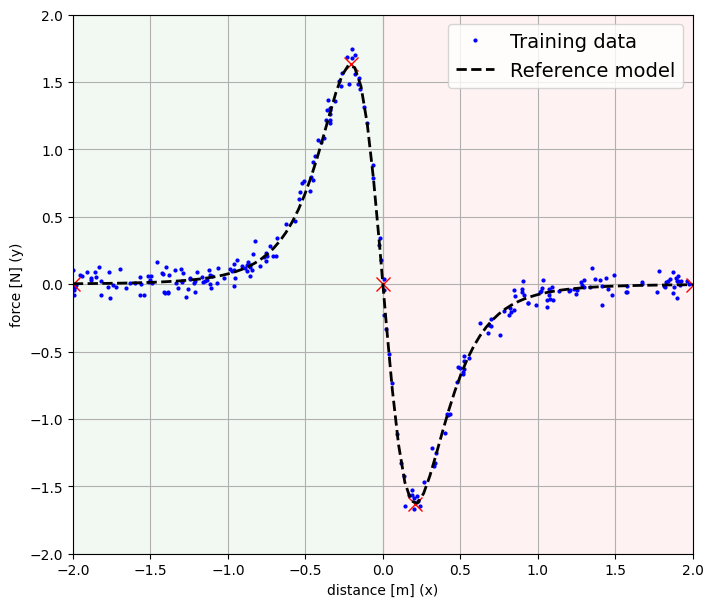

In [2]:
S = dataset.ABSDataset()
S.sample(size=250, noise=0.03, mesh=False)
#S.load('../data/magman.csv')
S.plot(width=8, height=7)

"""new_data = []
for dp in S.data:
    if dp.x < 0 and dp.y > 0 or \
       dp.x > 0 and dp.y < 0: new_data.append(dp)
S.data = new_data"""

S.index()
numbs.init(S)

In [3]:
unknown_stree_a = backprop.UnknownSyntaxTree('A')
unknown_stree_b = backprop.UnknownSyntaxTree('B')
stree     = backprop.BinaryOperatorSyntaxTree('/', unknown_stree_a, unknown_stree_b)
stree_pr  = stree.diff().simplify()
stree_pr2 = stree_pr.diff().simplify()
print(str(stree))
print(str(stree_pr))
print(str(stree_pr2))

(A(x) / B(x))
(((A'(x) * B(x)) - (A(x) * B'(x))) / (B(x) ^ 2))
((((((A''(x) * B(x)) + (A'(x) * B'(x))) - ((A'(x) * B'(x)) + (A(x) * B''(x)))) * (B(x) ^ 2)) - (((A'(x) * B(x)) - (A(x) * B'(x))) * ((2 * (B(x) ^ 1)) * B'(x)))) / (B(x) ^ 4))


In [4]:
hist_set = []
best_unkn_models = {}
best_k_mse = None
best_r2 = None

def onsynth_callback(synth_unkn_models:dict):
    global hist_set
    global best_unkn_models
    global best_k_mse
    global best_r2
    
    print('--- On Synth ---')
    for unkn in synth_unkn_models.keys():
        unkn_model, coeffs_mask, constrs = synth_unkn_models[unkn]
        print(f"{unkn}(x) =\n{unkn_model}")
    print()

    hist, __best_unkn_models, __best_r2, __best_k_mse = jump_backprop.jump_backprop(stree, stree_pr, synth_unkn_models, S, max_rounds=1)
    hist_set.append(hist)

    if best_k_mse is None or __best_k_mse < best_k_mse or (__best_k_mse == best_k_mse and __best_r2 > best_r2):
        best_unkn_models = __best_unkn_models
        best_k_mse = __best_k_mse
        best_r2 = __best_r2

lpbackprop.lpbackprop(S.knowledge, stree, onsynth_callback)

--- ASP Model ---
sign_unkn("A","-",-4,-3) sign_unkn("A","-",-3,-2) sign_unkn("A","-",-2,-1) sign_unkn("A","-",-1,0) sign_unkn("A","+",0,1) sign_unkn("A","+",1,2) sign_unkn("A","+",2,3) sign_unkn("A","+",3,4) sign_unkn("A","-",-1,-1) sign_unkn("A","+",1,1) sign_unkn("B","-",-4,-3) sign_unkn("B","-",-3,-2) sign_unkn("B","-",-2,-1) sign_unkn("B","-",-1,0) sign_unkn("B","-",0,1) sign_unkn("B","-",1,2) sign_unkn("B","-",2,3) sign_unkn("B","-",3,4) sign_unkn("B","-",-1,-1) sign_unkn("B","-",1,1) sign_unkn("A'","+",-1,-1) sign_unkn("A'","+",1,1) sign_unkn("A'","+",1,2) sign_unkn("A'","+",2,3) sign_unkn("A'","+",3,4) sign_unkn("A'","+",-4,-3) sign_unkn("A'","+",-3,-2) sign_unkn("A'","+",-2,-1) sign_unkn("A'","+",0,1) sign_unkn("A'","+",-1,0) sign_unkn("B'","+",-1,-1) sign_unkn("B'","-",1,1) sign_unkn("B'","-",1,2) sign_unkn("B'","-",2,3) sign_unkn("B'","-",3,4) sign_unkn("B'","+",-4,-3) sign_unkn("B'","+",-3,-2) sign_unkn("B'","+",-2,-1) sign_unkn("B'","-",0,1) sign_unkn("B'","+",-1,0) noroot

--- Best Syntax Tree ---
K-MSE: 0.022456390346151853
R2:    0.9872476131836235


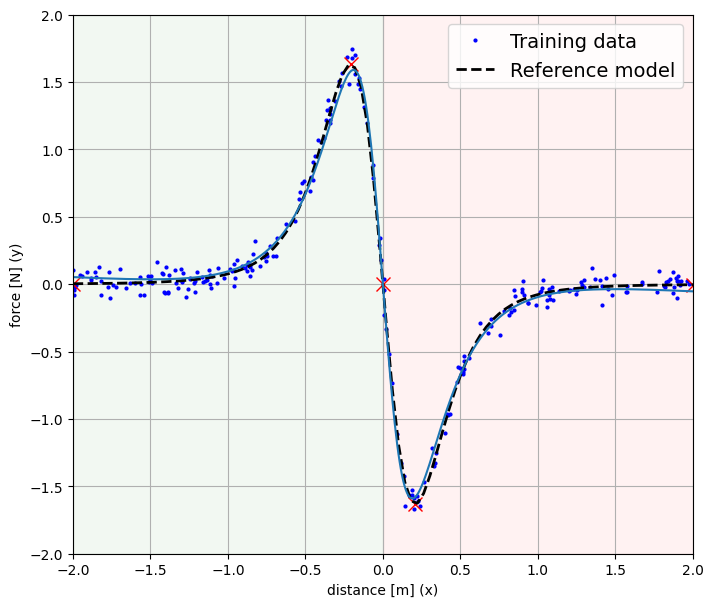

In [5]:
##
## set all synth_unkn_models.
##
#for model_name in synth_unkn_models_set[0].keys():
#    stree.set_unknown_model(model_name, *synth_unkn_models_set[0][model_name])

#
# show best stree.
#
if best_k_mse is None:
    #_, best_r2 = S.evaluate(stree.compute_output)
    raise RuntimeError('No model found.')
else:
    for unkn_label in best_unkn_models.keys():
        stree.set_unknown_model(unkn_label, best_unkn_models[unkn_label])

print("--- Best Syntax Tree ---")
print(f"K-MSE: {best_k_mse}")
print(f"R2:    {best_r2}")
S.plot(width=8, height=7)
xp = np.linspace(S.xl, S.xu, 500)
plt.plot(xp, stree.compute_output(xp));
plt.show()


--- Pull from A(x) ---


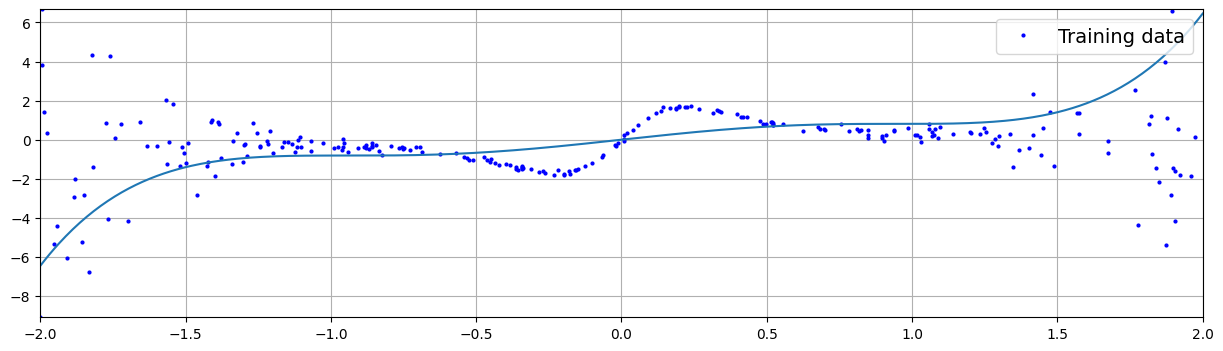

Model:
        5         3
0.4026 x - 1.207 x + 1.615 x
Coeffs Softmax:
[0.13196463 0.15220094 0.13196463 0.08604526 0.13196463 0.23389527
 0.13196463]
Coeffs:
[ 0.          0.40256018  0.         -1.20671408  0.          1.61494969
  0.        ]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 0.022456390346151853
R2:    0.9872476131836235


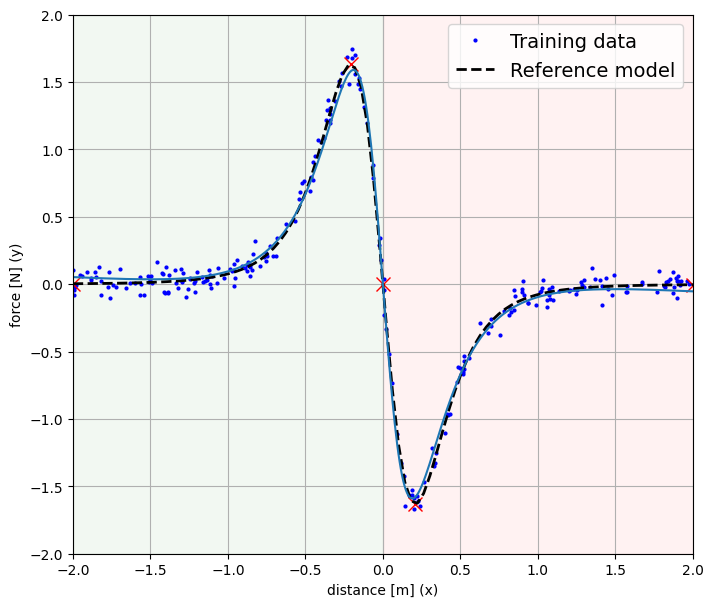



--- Pull from B(x) ---


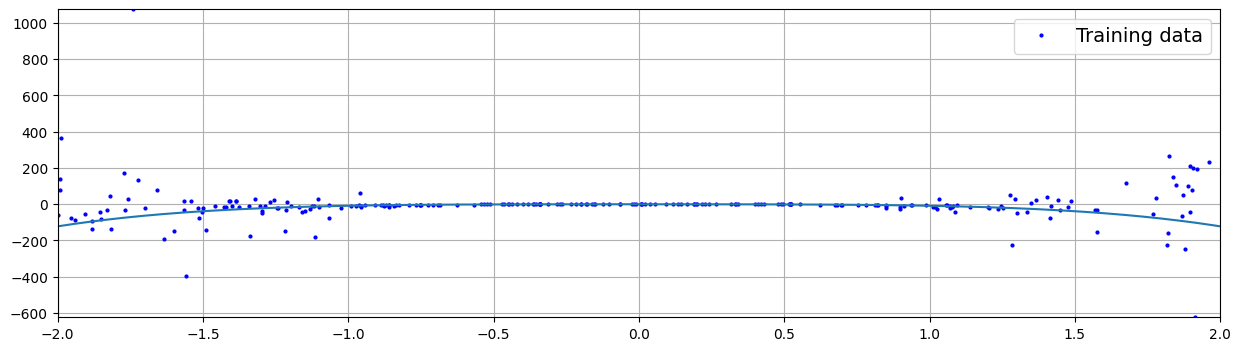

Model:
         6         4         2
-0.2447 x - 6.135 x - 2.024 x - 0.1067
Coeffs Softmax:
[0.15933958 0.16582206 0.06100253 0.16582206 0.11922944 0.16582206
 0.16296227]
Coeffs:
[-0.2446673   0.         -6.13544728  0.         -2.0238727   0.
 -0.10673608]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 0.022456390346151853
R2:    0.9872476131836235


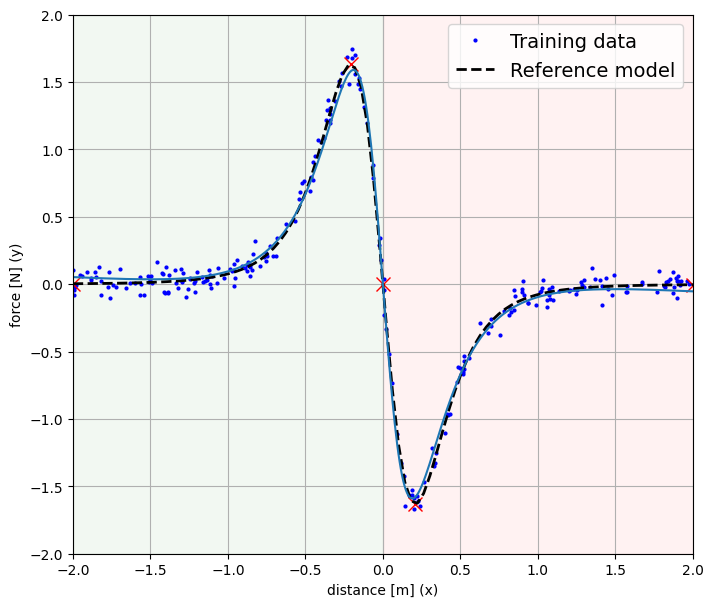



--- Pull from A(x) ---


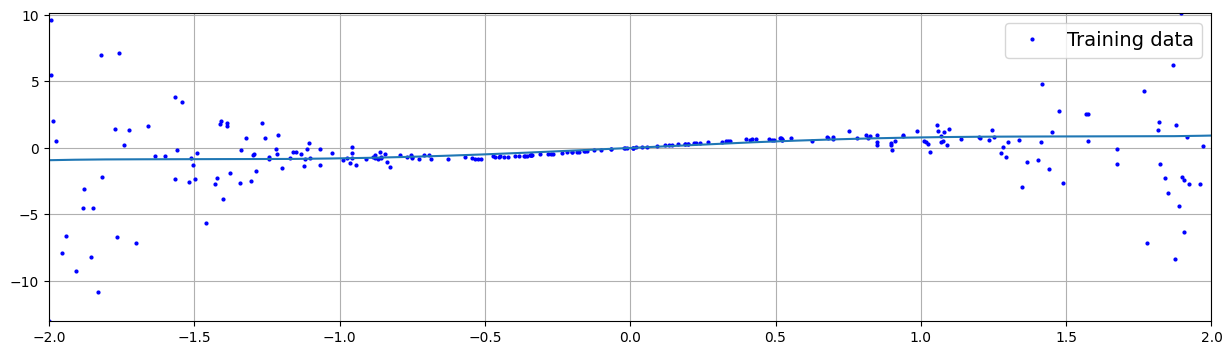

Model:
         5          3
0.03763 x - 0.2964 x + 1.048 x
Coeffs Softmax:
[0.12483084 0.12837397 0.12483084 0.10012761 0.12483084 0.27217506
 0.12483084]
Coeffs:
[ 0.          0.03762568  0.         -0.29644737  0.          1.04789914
  0.        ]

--- Pulled Eq/Ineq Constraints ---
A(-0.20827333) = -0.33618810612319777
A(0.20827333) = 0.33618810612319777
A(-2.00000000) = -0.44942471912327536
A(2.00000000) = 0.4494247191232483

--- Final Model ---
K-MSE: 0.008302287634989764
R2:    0.8732887599872429


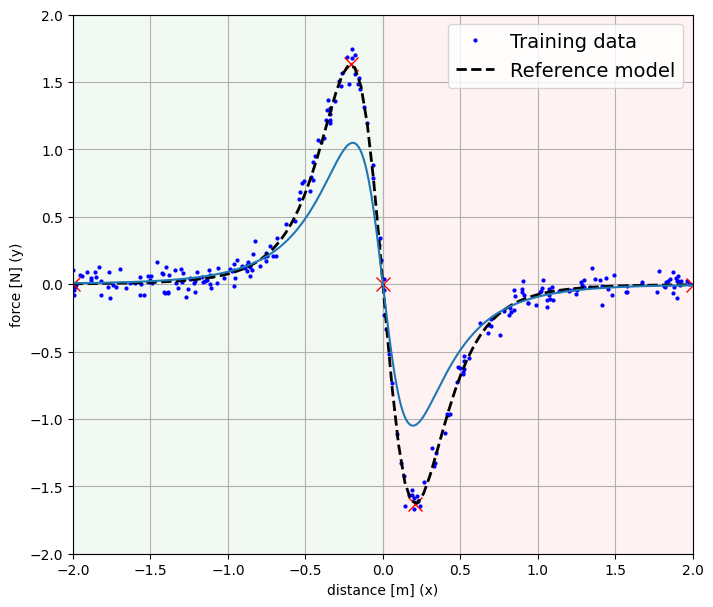



--- Pull from B(x) ---


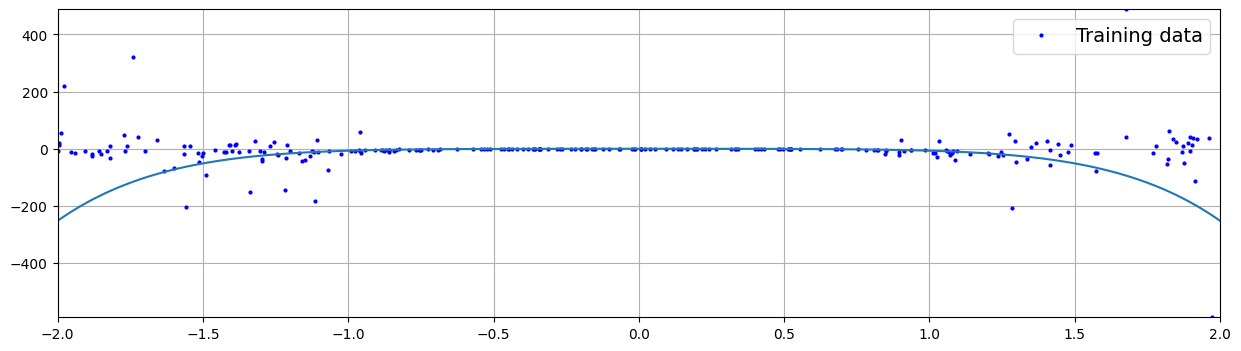

Model:
        6         4         2
-3.432 x - 1.537 x - 1.932 x - 0.05407
Coeffs Softmax:
[0.06615501 0.17982796 0.11491865 0.17982796 0.10242534 0.17982796
 0.17701713]
Coeffs:
[-3.43225769  0.         -1.53688312  0.         -1.93190276  0.
 -0.05407214]

--- Pulled Eq/Ineq Constraints ---
B(-0.20827333) = -0.13215964188605347
B(0.20827333) = -0.13215964188605347
B(-2.00000000) = -252.03659323248056
B(2.00000000) = -252.03659323249573

--- Final Model ---
K-MSE: 0.12038339534424218
R2:    0.9788422573976924


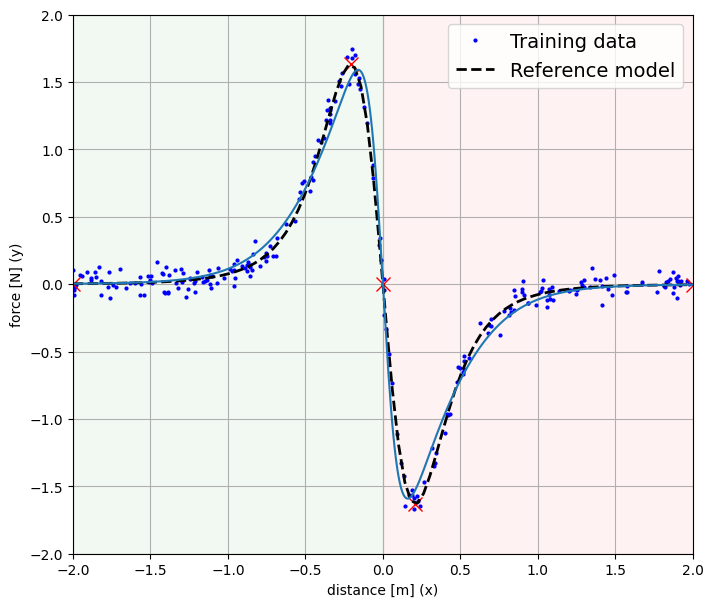

In [6]:
#
# show history (first Answer Set only).
#

constrmap = constraints.ConstraintMap()

for hist_entry in hist_set[0].entries:
    print(f"\n--- {hist_entry.msg} ---")
    
    if len(hist_entry.pulled_S.data) > 0:
        #y_scaled = utils.scale_y([dp.y for dp in hist_entry.pulled_S.data])
        #for i, dp in enumerate(hist_entry.pulled_S.data):
        #    dp.y = y_scaled[i]
        hist_entry.pulled_S.plot(width=15, height=4, plotref=False)
        xp = np.linspace(hist_entry.pulled_S.xl, hist_entry.pulled_S.xu, 500)
        plt.plot(xp, hist_entry.fit_model(xp));
        #plt.xlim(S.xl, S.xu)
        #plt.ylim(S.yl, S.yu)

        plt.show()
        model, _ = utils.simplify_poly(hist_entry.fit_model, None)
        print(f"Model:\n{model}")
        print(f"Coeffs Softmax:\n{utils.coeffs_softmax(model.c)}")
        print(f"Coeffs:\n{model.c}")

    print("\n--- Pulled Eq/Ineq Constraints ---")
    for derivdeg in hist_entry.pulled_constrs.keys():
        for (dp, relopt) in hist_entry.pulled_constrs[derivdeg].eq_ineq:
            dp_x_str = "{:.8f}".format(dp.x)
            dp_y_str = str(dp.y) #"{:.8f}".format(dp.y)
            prime_sign = "'" * derivdeg
            constrmap.add(hist_entry.model_name + prime_sign, dp.x, dp.y, relopt)
            print(f"{hist_entry.model_name}{prime_sign}({dp_x_str}) {relopt.opt} {dp_y_str}")
    
    if len(hist_entry.violated_constrs) > 0:
        print("\n--- Violated Constraints ---")
        for (dp, relopt) in hist_entry.violated_constrs:
            dp_x_str = "{:.2f}".format(dp.x)
            dp_y_str = "{:.2f}".format(dp.y)
            print(f"m({dp_x_str}) {relopt.opt} {dp_y_str}")

    print("\n--- Final Model ---") 
    stree.set_unknown_model(hist_entry.model_name, hist_entry.fit_model)
    _, r2, k_mse = S.evaluate(stree.compute_output)
    print(f"K-MSE: {k_mse}")
    print(f"R2:    {r2}")
    
    S.plot(width=8, height=7)
    xp = np.linspace(S.xl, S.xu, 500)
    plt.plot(xp, stree.compute_output(xp));
    plt.show()

    print()